<a href="https://colab.research.google.com/github/joSanchez28/BERT_on_tweets/blob/master/BERT_FineTuning_con_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning de el transformador BERT para el análisis de sentimientos en Twitter

En esta libreta se pretende hacer transfer learning con el modelo BERT preentrenado disponible gracias a HuggingFace con el objetivo de resolver la tarea de análisis o clasificación de sentimientos en tweets.

Al final de esta libreta se puede encontrar que la precisión que conseguimos tras el entrenamiento es de 0.826 en el conjunto de validación. Un análisis más exhaustivo de la eficacia del modelo será llevado a cabo en otra libreta.




El código se puede ejecutar directamente en la plataforma Google Colab. No obstante, a la hora de ejecutarla es conveniente tener en cuenta que ha sido originalmente ejecutada con Google Colab Pro (con el aumento de recursos que esto conlleva con respecto a la versión estándar). Si estás usando Google Colab, puedes comprobar la GPU a tu disposición ejecutando la siguiente celda.




In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 10 20:56:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Cargamos los paquetes necesarios


In [0]:
import os
import pandas as pd
import re
import time
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!pip install pyyaml h5py  # Para guardar los modelos en formato HDF5

En concreto, importamos las funciones del paquete de HuggingFace necesarias para cargar BERT con los pesos preentrenados y con la estructura adecuada para hacer clasificación de sentimientos con dos clases.


In [0]:
pip install transformers

     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 890kB 14.3MB/s 
     |████████████████████████████████| 1.0MB 16.5MB/s 
     |████████████████████████████████| 3.8MB 24.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a3160942d72e061414b94cdea2cbedf9f1cf3fdd0db9df7a396fd9a82c2f30b6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertForSequenceClassification,
    glue_convert_examples_to_features,
    glue_processors,
)

In [0]:
# Parámetros del script usado por HuggingFace para hacer análisis de sentimientos sobre otro conjunto de datos
USE_XLA = False
USE_AMP = False
TASK = "sst-2"
TFDS_TASK = "sst2"
num_labels = 2
tf.config.optimizer.set_jit(USE_XLA)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": USE_AMP})

In [0]:
# Load tokenizer and model from pretrained model/vocabulary. Specify the number of labels to classify (2+: classification, 1: regression)
config = BertConfig.from_pretrained("bert-base-cased", num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = TFBertForSequenceClassification.from_pretrained("bert-base-cased", config=config)

## Nuestro conjunto de datos
En esta sección, cargamos y preprocesamos nuestro conjunto de tweets.


Cargamos el conjunto de datos y lo metemos en un dataframe de pandas.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

dataset_filename = "training.1600000.processed.noemoticon.csv"
dataset_path = "/content/drive/My Drive/" + dataset_filename
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/My Drive/training.1600000.processed.noemoticon.csv


In [0]:
print(df["text"][0])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [0]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Preprocesado del conjunto de datos

Cambiamos los nombres de usuario por la palabra 'USER' y las direcciones url por la palabra 'URL'. No quitamos los signos de puntuación porque BERT trabaja con ellos.



In [0]:
# Para detectar urls y sustituirlas por URL
TEXT_URL = "https?:\S+|http?:\S|www\.\S+|\S+\.(com|org|co|us|uk|net|gov|edu)"
# Para detectar nombres de usuario y sustituirlos por USER
TEXT_USER = "@\S+"
#TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9,;:.']+" #La última indica lo que dejamos; BERT sí trabaja con signos de puntuación.

In [0]:
def preprocess(text):
    # Remove link,user and special characters
    #text = re.sub(TEXT_CLEANING_RE, ' ', text).strip()
    text = re.sub(TEXT_URL,  'URL',    text)           # Delete pattern abc
    text = re.sub(TEXT_USER,  'USER', text)           # Replace pattern abc -> def
    text = re.sub(r'\s+', ' ',   text).strip()        # Eliminamos dobles espacios en blanco y los espacios en blanco al principio o al final
    return text

In [0]:
df.text = df.text.apply(lambda x: preprocess(x))

In [0]:

print(df["text"][0])

USER URL - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D


In [0]:
df.text.iloc[919]

'USER - Who should I contact if I need a 1099 for freelance work I did on URL throughout 2008? Never got one.'

Cambiamos las etiquetas positivas de 4 a 1 para reutilizar las funciones de HuggingFace.

In [0]:
df.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [0]:
decode_map = {0: 0, 4: 1}
def decode_sentiment(label):
    return decode_map[int(label)]

df.target = df.target.apply(lambda x: decode_sentiment(x))

In [0]:
df.target.value_counts()

1    800000
0    800000
Name: target, dtype: int64

### Creamos los conjuntos de entrenamiento, validación y test

In [0]:
df_relevante = df[["target","text"]]

In [0]:
df_relevante.columns = ["label", "sentence"]
df_relevante.index.name = "idx"

In [0]:
df_relevante = df_relevante.reset_index()

In [0]:
df_relevante.head()

,idx,label,sentence
0,0,0,"USER URL - Awww, that's a bummer. You shoulda ..."
1,1,0,is upset that he can't update his Facebook by ...
2,2,0,USER I dived many times for the ball. Managed ...
3,3,0,my whole body feels itchy and like its on fire
4,4,0,"USER no, it's not behaving at all. i'm mad. wh..."


#### Split the dataset

In [0]:
df_train, df_test = train_test_split(df_relevante, test_size = 1 - TRAIN_SIZE, random_state = 0, stratify = df_relevante.label.values)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = 0, stratify = df_test.label.values)

In [0]:
df_train.shape

(1280000, 3)

In [0]:
df_train.label.value_counts()

1    640000
0    640000
Name: label, dtype: int64

In [0]:
df_test.shape

(160000, 3)

In [0]:
df_test.label.value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [0]:
a = "adas asf gfd"
len(a.split())

3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


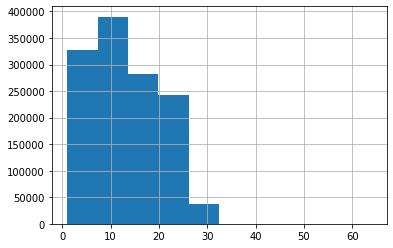

In [0]:
df_train["n_words"] = df_train["sentence"].str.split().str.len() #df_train.sentence.apply(lambda x: len(x.split()))
df_train["n_words"].hist()

In [0]:
df_train["n_words"].value_counts()

7     71532
8     70902
6     69636
9     69570
10    66960
5     64627
11    64244
12    60953
13    57469
4     54283
14    54269
15    50863
16    47986
17    44897
18    43122
3     41687
19    41369
20    41280
21    38658
22    38297
23    36458
24    34026
25    29905
26    23871
2     20012
27    16982
28    10622
29     5882
1      4792
30     2861
31     1268
32      464
33      166
34       52
35       19
36        5
39        3
37        2
58        1
38        1
41        1
44        1
57        1
64        1
Name: n_words, dtype: int64

#### Convertimos los conjuntos de datos a un formato con el que pueda trabajar BERT

En primer lugar, transformamos los conjuntos de datos en tensores (de TensorFlow).

In [0]:
train_examples = df_train.shape[0]
valid_examples = df_val.shape[0]
print(train_examples)
print(valid_examples)

1280000
160000


In [0]:
data_train = tf.data.Dataset.from_tensor_slices(df_train.to_dict('list'))

In [0]:
data_val = tf.data.Dataset.from_tensor_slices(df_val.to_dict('list'))

In [0]:
#data_test = tf.data.Dataset.from_tensor_slices(df_test.to_dict('list'))

A continuación, le damos a los tensores el formato que requiere el modelo BERT desarrollado por HuggingFace (aprovechamos las funciones que usan en uno de sus scripts para hacer también clasificaciónd de sentimientos).



In [0]:
train_dataset = glue_convert_examples_to_features(data_train, tokenizer, max_length=40, task=TASK) #O:128 #2:36

In [0]:
valid_dataset = glue_convert_examples_to_features(data_val, tokenizer, max_length=40, task=TASK) #O:128

In [0]:
#test_dataset = glue_convert_examples_to_features(data_test, tokenizer, max_length=36, task=TASK) #O:128

## ENTRENAMOS EL MODELO


In [0]:
EPOCHS = 6
BATCH_SIZE = 32
EVAL_BATCH_SIZE = BATCH_SIZE * 2

In [0]:
# MNLI expects either validation_matched or validation_mismatched
train_dataset = train_dataset.shuffle(128).batch(BATCH_SIZE).repeat(-1) #Original:128 <- 1000
valid_dataset = valid_dataset.batch(EVAL_BATCH_SIZE)

In [0]:
checkpoint_path = "/content/drive/My Drive/" 
checkpoint_dir = os.path.dirname(checkpoint_path)

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path + 'my_best_model_BERT.{epoch:02d}-{val_accuracy:.2f}.h5', 
    verbose=1, save_best_only=True, save_weights_only=False, monitor = 'val_accuracy', mode = 'max'), 
    time_callback
  ]

In [0]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)
if USE_AMP:
    # loss scaling is currently required when using mixed precision
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, "dynamic")


if num_labels == 1:
    loss = tf.keras.losses.MeanSquaredError()
else:
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
model.compile(optimizer=opt, loss=loss, metrics=[metric])

# Train and evaluate using tf.keras.Model.fit()
train_steps = train_examples // BATCH_SIZE
valid_steps = valid_examples // EVAL_BATCH_SIZE

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    verbose = 1,
    callbacks=my_callbacks
)

# Save TF2 model
#os.makedirs("./save/", exist_ok=True)
#model.save_pretrained("./save/")

Epoch 1/6
40000/40000 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8484
Epoch 00001: val_accuracy improved from -inf to 0.86144, saving model to /content/drive/My Drive/my_best_model_BERT.01-0.86.h5
40000/40000 [==============================] - 7706s 193ms/step - loss: 0.3451 - accuracy: 0.8484 - val_loss: 0.3248 - val_accuracy: 0.8614
Epoch 2/6
17088/40000 [===========>..................] - ETA: 1:10:20 - loss: 0.3000 - accuracy: 0.8715Buffered data was truncated after reaching the output size limit.

Guardamos el modelo.


In [0]:
model.save(checkpoint_path + 'final_model_BERT_aaa.tf', save_format="tf")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/final_model_BERT_aaa.tf/assets


Guardamos también los datos monitorizados durante el entrenamiento.


In [0]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = checkpoint_path + 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [0]:
time_callback.times

[7725.498257160187,
 7716.965488433838,
 7697.0326380729675,
 7673.538458108902,
 7708.860443115234,
 7700.723967552185]

In [0]:
hist_df["times"] = time_callback.times
hist_df

,loss,accuracy,val_loss,val_accuracy,times
0,0.345056,0.848356,0.324759,0.861437,7725.498257
1,0.291392,0.875852,0.334871,0.862175,7716.965488
2,0.252322,0.895064,0.350954,0.860100,7697.032638
3,0.218343,0.911066,0.382523,0.857200,7673.538458
4,0.199844,0.919542,0.413832,0.854669,7708.860443
5,0.175974,0.929823,0.456333,0.853669,7700.723968


In [0]:
# save to json:  
hist_json_file = checkpoint_path + 'history_with_times.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)